Walk through two key unsupervised learning algorithms: clustering and anomaly detection.

#### Helpers

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

In [7]:
def load_data():
    X = np.load("data/ex7_X.npy")
    return X

def draw_line(p1, p2, style="-k", linewidth=1):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], style, linewidth=linewidth)

def plot_data_points(X, idx):
    # Define colormap to match Figure 1 in the notebook
    cmap = ListedColormap(["red", "green", "blue"])
    c = cmap(idx)
    
    # plots data points in X, coloring them so that those with the same
    # index assignments in idx have the same color
    plt.scatter(X[:, 0], X[:, 1], facecolors='none', edgecolors=c, linewidth=0.1, alpha=0.7)

def plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i):
    # Plot the examples
    plot_data_points(X, idx)
    
    # Plot the centroids as black 'x's
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='k', linewidths=3)
    
    # Plot history of the centroids with lines
    for j in range(centroids.shape[0]):
        draw_line(centroids[j, :], previous_centroids[j, :])
    
    plt.title("Iteration number %d" %i)

#### Clustering (K-means algorithm)

The K-means algorithm is a method to automatically cluster similar
data points together. 

* Concretely, you are given a training set $\{x^{(1)}, ..., x^{(m)}\}$, and you want
to group the data into a few cohesive “clusters”. 


* K-means is an iterative procedure that
     * Starts by guessing the initial centroids, and then 
     * Refines this guess by 
         * Repeatedly assigning examples to their closest centroids, and then 
         * Recomputing the centroids based on the assignments.
         

* In pseudocode, the K-means algorithm is as follows:

    ``` python
    # Initialize centroids
    # K is the number of clusters
    centroids = kMeans_init_centroids(X, K)
    
    for iter in range(iterations):
        # Cluster assignment step: 
        # Assign each data point to the closest centroid. 
        # idx[i] corresponds to the index of the centroid 
        # assigned to example i
        idx = find_closest_centroids(X, centroids)

        # Move centroid step: 
        # Compute means based on centroid assignments
        centroids = compute_centroids(X, idx, K)
    ```


* The inner-loop of the algorithm repeatedly carries out two steps: 
    1. Assigning each training example $x^{(i)}$ to its closest centroid, and
    2. Recomputing the mean of each centroid using the points assigned to it. 
    
    
* The $K$-means algorithm will always converge to some final set of means for the centroids. 

* However, the converged solution may not always be ideal and depends on the initial setting of the centroids.
    * Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. 
    * One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion).

How it works:
1. First we randomly initialize K points called means or cluster centroids $\mu_{1}, \mu_{2}, ..., \mu_{K}$.
2. We categorize each item to its closest mean and we update the mean's coordinates, which are the averages of the items categorized in that cluster so far.
3. We repeat the process for a given number of iterations and at the end, we have our clusters.

Note that with k-means random initialization, we might end up with initial centroids that are too close to each others, or don't yield good clustering, thus one way around it is to run k-means with random initialization several times, then compute the cost function **J** for each one and pick the set of clusters that gave lowest cost **J**.

<b>Finding closest centroids</b>

* This function takes the data matrix `X` and the locations of all
centroids inside `centroids` 
* It should output a one-dimensional array `idx` (which has the same number of elements as `X`) that holds the index  of the closest centroid (a value in $\{0,...,K-1\}$, where $K$ is total number of centroids) to every training example . *(Note: The index range 0 to K-1 varies slightly from what is shown in the lectures (i.e. 1 to K) because Python list indices start at 0 instead of 1)*
* Specifically, for every example $x^{(i)}$ we set
$$c^{(i)} := j \quad \mathrm{that \; minimizes} \quad ||x^{(i)} - \mu_j||^2,$$
where 
 * $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$ (corresponds to `idx[i]` in the starter code), and 
 * $\mu_j$ is the position (value) of the $j$’th centroid. (stored in `centroids` in the starter code)
 * $||x^{(i)} - \mu_j||$ is the L2-norm
 


In [1]:
def find_closest_centroids(X, centroids):
    """
    Computes the centroid memberships for every example
    
    Args:
        X (ndarray): (m, n) Input values      
        centroids (ndarray): (K, n) centroids
    
    Returns:
        idx (array_like): (m,) closest centroids
    
    """

    # Set K
    K = centroids.shape[0]

    # You need to return the following variables correctly
    idx = np.zeros(X.shape[0], dtype=int)

    for i in range(X.shape[0]):
        distances = []
        
        for j in range(centroids.shape[0]):
            norm_ij = np.linalg.norm(X[i] - centroids[j])  #
            distances.append(norm_ij)
        
        idx[i] = np.argmin(distances)
    
    return idx

<b>Computing centroid means</b>

* Specifically, for every centroid $\mu_k$ we set
$$\mu_k = \frac{1}{|C_k|} \sum_{i \in C_k} x^{(i)}$$ 

    where 
    * $C_k$ is the set of examples that are assigned to centroid $k$
    * $|C_k|$ is the number of examples in the set $C_k$


* Concretely, if two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid $k=2$,
then you should update $\mu_2 = \frac{1}{2}(x^{(3)}+x^{(5)})$.

In [2]:
def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the 
    data points assigned to each centroid.
    
    Args:
        X (ndarray):   (m, n) Data points
        idx (ndarray): (m,) Array containing index of closest centroid for each 
                       example in X. Concretely, idx[i] contains the index of 
                       the centroid closest to example i
        K (int):       number of centroids
    
    Returns:
        centroids (ndarray): (K, n) New centroids computed
    """
    
    # Useful variables
    m, n = X.shape
    
    # You need to return the following variables correctly
    centroids = np.zeros((K, n))
    
    for k in range(K):
        points = X[idx == k]
        centroids[k] = np.mean(points, axis = 0) 
    
    return centroids

<b>K-means on a sample dataset</b>

In [3]:
def run_kMeans(X, initial_centroids, max_iters=10, plot_progress=False):
    """
    Runs the K-Means algorithm on data matrix X, where each row of X
    is a single example
    """
    
    # Initialize values
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids    
    idx = np.zeros(m)
    plt.figure(figsize=(8, 6))

    # Run K-Means
    for i in range(max_iters):
        
        #Output progress
        print("K-Means iteration %d/%d" % (i, max_iters-1))
        
        # For each example in X, assign it to the closest centroid
        idx = find_closest_centroids(X, centroids)
        
        # Optionally plot progress
        if plot_progress:
            plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i)
            previous_centroids = centroids
            
        # Given the memberships, compute new centroids
        centroids = compute_centroids(X, idx, K)
    plt.show() 
    return centroids, idx

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9


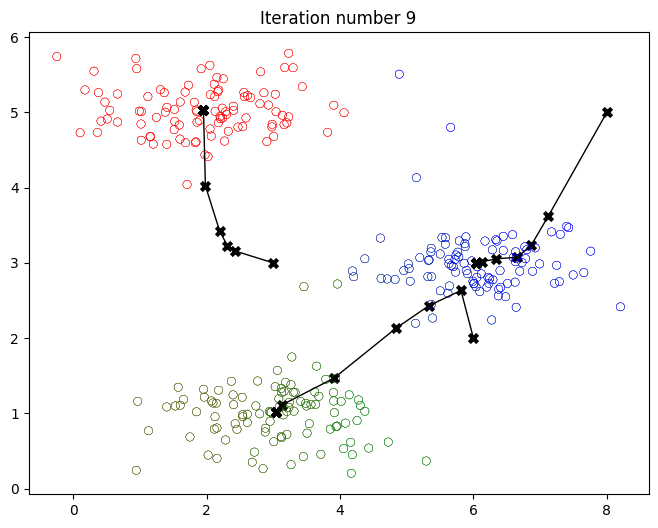

In [10]:
# Load an example dataset
X = load_data()

# Set initial centroids
initial_centroids = np.array([[3,3],[6,2],[8,5]])

# Number of iterations
max_iters = 10

# Run K-Means
centroids, idx = run_kMeans(X, initial_centroids, max_iters, plot_progress=True)

In [11]:
centroids, idx

(array([[1.95399466, 5.02557006],
        [3.04367119, 1.01541041],
        [6.03366736, 3.00052511]]),
 array([0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        